In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported!")

# Generate same data as Week 1 (using same seed for consistency)
np.random.seed(42)
dates = pd.date_range(start='2019-01-01', end='2024-01-01', freq='B')

start_prices = {'SPY': 250, 'QQQ': 160, 'IWM': 140, 'EFA': 60, 'TLT': 120, 'GLD': 120}
params = {
    'SPY': {'mu': 0.12, 'sigma': 0.18},
    'QQQ': {'mu': 0.15, 'sigma': 0.22},
    'IWM': {'mu': 0.10, 'sigma': 0.24},
    'EFA': {'mu': 0.08, 'sigma': 0.20},
    'TLT': {'mu': 0.02, 'sigma': 0.12},
    'GLD': {'mu': 0.05, 'sigma': 0.16}
}

data = pd.DataFrame(index=dates)
for ticker in ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT', 'GLD']:
    mu = params[ticker]['mu'] / 252
    sigma = params[ticker]['sigma'] / np.sqrt(252)
    returns = np.random.normal(mu, sigma, len(dates))
    prices = start_prices[ticker] * np.exp(np.cumsum(returns))
    data[ticker] = prices

returns = data.pct_change().dropna()

print(f"\nData loaded: {data.shape[0]} days, {data.shape[1]} assets")
print(f"Returns shape: {returns.shape}")

Libraries imported!

Data loaded: 1305 days, 6 assets
Returns shape: (1304, 6)


In [2]:
def portfolio_stats(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and volatility"""
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    """Negative Sharpe ratio for minimization"""
    p_return, p_std = portfolio_stats(weights, mean_returns, cov_matrix)
    sharpe = (p_return - risk_free_rate) / p_std
    return -sharpe

def optimize_portfolio(mean_returns, cov_matrix):
    """Optimize portfolio to maximize Sharpe ratio"""
    num_assets = len(mean_returns)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    
    result = minimize(negative_sharpe, init_guess, 
                     args=(mean_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

print("Optimization functions defined!")

Optimization functions defined!


In [3]:
# Calculate baseline statistics
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

# Optimize baseline portfolio
baseline_weights = optimize_portfolio(mean_returns, cov_matrix)

print("BASELINE PORTFOLIO (Original Data):")
print("="*50)
for ticker, weight in zip(data.columns, baseline_weights):
    print(f"  {ticker}: {weight*100:.2f}%")

baseline_return, baseline_std = portfolio_stats(baseline_weights, mean_returns, cov_matrix)
baseline_sharpe = (baseline_return - 0.02) / baseline_std

print(f"\nPortfolio Metrics:")
print(f"  Expected Return: {baseline_return*100:.2f}%")
print(f"  Volatility: {baseline_std*100:.2f}%")
print(f"  Sharpe Ratio: {baseline_sharpe:.3f}")

BASELINE PORTFOLIO (Original Data):
  SPY: 52.78%
  QQQ: 38.43%
  IWM: 6.66%
  EFA: 0.00%
  TLT: 0.00%
  GLD: 2.13%

Portfolio Metrics:
  Expected Return: 23.80%
  Volatility: 12.72%
  Sharpe Ratio: 1.715


In [4]:
# Experiment: Add small noise to mean returns
np.random.seed(123)

print("ESTIMATION ERROR EXPERIMENT")
print("="*60)
print("\nPerturbing mean returns by tiny amounts (±1-2%)...\n")

# Store results
num_perturbations = 5
perturbation_results = []

for i in range(num_perturbations):
    # Add small random noise to mean returns (1-2% change)
    noise = np.random.normal(0, 0.01, len(mean_returns))  # ±1% noise
    perturbed_returns = mean_returns + noise
    
    # Optimize with perturbed data
    perturbed_weights = optimize_portfolio(perturbed_returns, cov_matrix)
    perturbation_results.append(perturbed_weights)
    
    print(f"Perturbation {i+1}:")
    for ticker, orig_weight, new_weight in zip(data.columns, baseline_weights, perturbed_weights):
        change = (new_weight - orig_weight) * 100
        print(f"  {ticker}: {orig_weight*100:5.2f}% → {new_weight*100:5.2f}% (change: {change:+6.2f}%)")
    print()

# Calculate weight changes
perturbation_results = np.array(perturbation_results)
max_weight_change = np.abs(perturbation_results - baseline_weights).max(axis=0) * 100

print("="*60)
print("MAXIMUM WEIGHT CHANGES:")
for ticker, max_change in zip(data.columns, max_weight_change):
    print(f"  {ticker}: up to {max_change:.2f}% change")

ESTIMATION ERROR EXPERIMENT

Perturbing mean returns by tiny amounts (±1-2%)...

Perturbation 1:
  SPY: 52.78% → 48.41% (change:  -4.37%)
  QQQ: 38.43% → 38.62% (change:  +0.19%)
  IWM:  6.66% →  6.65% (change:  -0.01%)
  EFA:  0.00% →  0.00% (change:  +0.00%)
  TLT:  0.00% →  0.00% (change:  +0.00%)
  GLD:  2.13% →  6.32% (change:  +4.18%)

Perturbation 2:
  SPY: 52.78% → 49.63% (change:  -3.15%)
  QQQ: 38.43% → 39.69% (change:  +1.27%)
  IWM:  6.66% →  8.74% (change:  +2.08%)
  EFA:  0.00% →  0.00% (change:  +0.00%)
  TLT:  0.00% →  0.00% (change:  -0.00%)
  GLD:  2.13% →  1.94% (change:  -0.19%)

Perturbation 3:
  SPY: 52.78% → 52.23% (change:  -0.56%)
  QQQ: 38.43% → 34.91% (change:  -3.52%)
  IWM:  6.66% →  5.57% (change:  -1.09%)
  EFA:  0.00% →  0.00% (change:  +0.00%)
  TLT:  0.00% →  0.00% (change:  -0.00%)
  GLD:  2.13% →  7.30% (change:  +5.17%)

Perturbation 4:
  SPY: 52.78% → 51.55% (change:  -1.23%)
  QQQ: 38.43% → 36.55% (change:  -1.88%)
  IWM:  6.66% →  7.02% (change: 

/var/folders/49/cjmp495j7r75tyzd_gh6kjm40000gn/T/ipykernel_82694/291166982.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([weight_changes[:, i] for i in range(len(data.columns))],


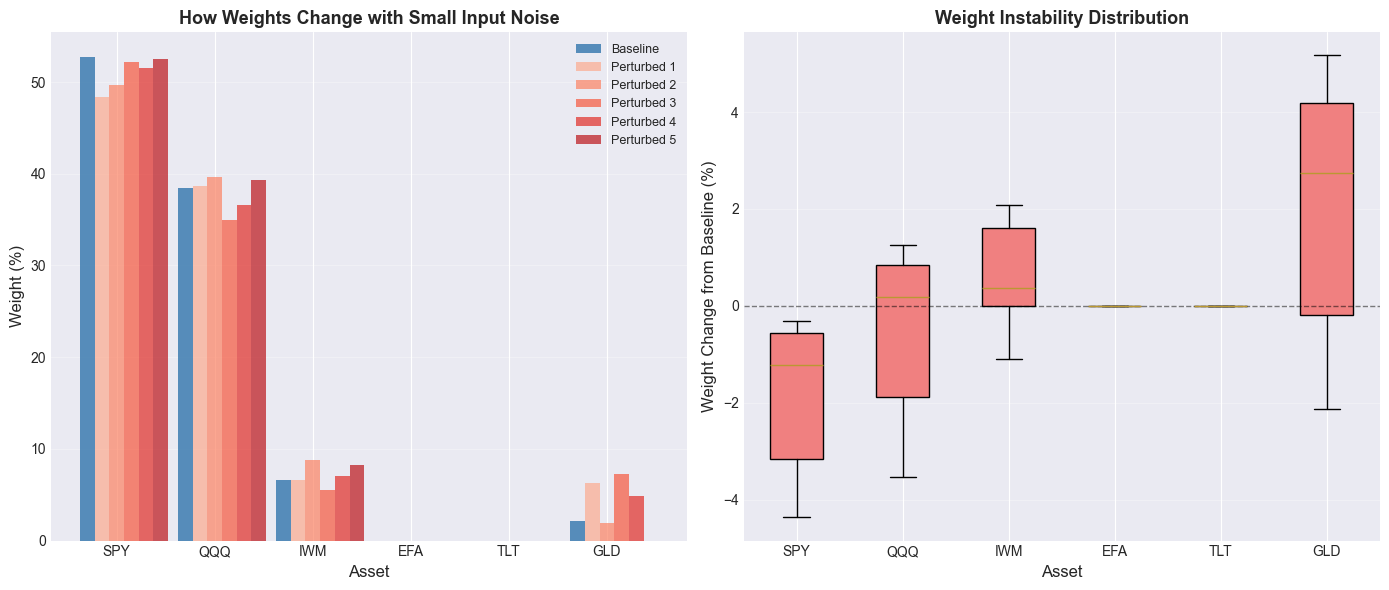


KEY INSIGHT: ESTIMATION ERROR AMPLIFICATION
Input change: ±1% to expected returns
Output change: up to 5.2% to portfolio weights

Amplification factor: ~5x

Conclusion: The optimizer is EXTREMELY sensitive to input estimates.


In [6]:
# Visualize weight instability
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: All portfolios overlaid
ax1 = axes[0]
x = np.arange(len(data.columns))
width = 0.15

# Plot baseline
ax1.bar(x - 2*width, baseline_weights * 100, width, label='Baseline', alpha=0.9, color='steelblue')

# Plot each perturbation
colors = plt.cm.Reds(np.linspace(0.3, 0.8, num_perturbations))
for i, weights in enumerate(perturbation_results):
    ax1.bar(x + (i-1)*width, weights * 100, width, 
           label=f'Perturbed {i+1}', alpha=0.7, color=colors[i])

ax1.set_xlabel('Asset', fontsize=12)
ax1.set_ylabel('Weight (%)', fontsize=12)
ax1.set_title('How Weights Change with Small Input Noise', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(data.columns)
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, alpha=0.3, axis='y')

# Right plot: Weight change distribution (boxplot)
ax2 = axes[1]
weight_changes = (perturbation_results - baseline_weights) * 100
bp = ax2.boxplot([weight_changes[:, i] for i in range(len(data.columns))],
                  labels=data.columns, patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')

ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Asset', fontsize=12)
ax2.set_ylabel('Weight Change from Baseline (%)', fontsize=12)
ax2.set_title('Weight Instability Distribution', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHT: ESTIMATION ERROR AMPLIFICATION")
print("="*60)
print("Input change: ±1% to expected returns")
print(f"Output change: up to {max_weight_change.max():.1f}% to portfolio weights")
print(f"\nAmplification factor: ~{max_weight_change.max():.0f}x")
print("\nConclusion: The optimizer is EXTREMELY sensitive to input estimates.")